# Gannett Modeling Challenge

### Setting Up

In this section, I will load the required modules and read in the data.

In [1]:
## import required packages
import IPython
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import category_encoders as ce
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
## get column names for data frame
headers = open("./assets/header.txt","r+") 
colnames = headers.read()
columns = colnames.replace("\n", " ").split(", ")[:-1]
headers.close

<function TextIOWrapper.close()>

In [3]:
## load csv and assign column names
data = pd.read_csv('./assets/data.csv', names = columns) 
data.head()

,CPL_wrt_BC,client_state,duration,num_prods,calls,CPL_wrt_self,churn,avg_budget,BC,clicks
0,0.000000,AZ,73,6,2,NaN,1,10082.152554,Beauty & Personal Care,107
1,-0.623618,CA,1,1,3,0.000000,0,133.928571,"Shopping, Collectibles & Gifts (General)",79
2,0.007905,NY,102,2,8,-0.292008,0,3935.017462,"Personal Services (Weddings, Cleaners, etc.)",90
3,-0.104900,MN,6,1,5,0.587206,0,461.538462,Travel,112
4,-0.013057,NJ,34,1,6,-0.955335,1,314.705882,Health & Fitness,95


### EDA

Now that I have the data frame, I will explore the dataset and check the following:

1. Missingness: If there are any columns with missing values, either impute the missing values or drop the column if a significant proportion of values are missing.
2. Balance: Ideally, the dataset is evenly split between customers that churned and customers that stayed. If the dataset is very imbalanced (ex. 99% of customers in dataset stayed), a model that always predicts "0" can get very high accuracy.
3. Cardinality: most implementations of machine learning models struggle with categorical input, so for the categorical variables (client_state and BC), determine the number of values that each can take. If it's a low-cardinality variable, I can simply make dummy variables to use for modeling.

I will modify the dataset in the next section based on what I find.

In [4]:
## check data frame for missing values
NA_count = data.isnull().sum()
NA_info = pd.DataFrame({'NA_count': NA_count})
print(NA_info)

              NA_count
CPL_wrt_BC           0
client_state         0
duration             0
num_prods            0
calls                0
CPL_wrt_self      1092
churn                0
avg_budget           0
BC                   0
clicks               0


In [5]:
has_missing = data[data["CPL_wrt_self"].isnull()]
has_missing.head(10)

,CPL_wrt_BC,client_state,duration,num_prods,calls,CPL_wrt_self,churn,avg_budget,BC,clicks
0,0.000000,AZ,73,6,2,NaN,1,10082.152554,Beauty & Personal Care,107
8,0.000000,MD,53,2,3,NaN,0,2812.286923,Home & Home Improvement,113
21,0.000000,WA,36,4,1,NaN,0,2257.655829,Home & Home Improvement,73
35,0.000000,CA,108,3,4,NaN,0,510.823940,Home & Home Improvement,132
68,0.000000,IL,40,4,8,NaN,0,7924.382535,Home & Home Improvement,65
85,0.000000,GA,62,4,2,NaN,0,1438.468633,Furniture,129
87,-0.111111,CA,56,2,4,NaN,1,2096.359612,Home & Home Improvement,131
105,0.000000,NY,36,3,2,NaN,0,2092.187653,Home & Home Improvement,65
108,0.000000,FL,31,2,9,NaN,0,1558.546529,Home & Home Improvement,97
114,-0.094938,NH,6,1,7,NaN,0,1606.624487,Automotive -- For Sale,101


In [6]:
## check if CPL_wrt_self being NA implies CPL_wrt_BC is a certain value (i.e. 0)
len(has_missing["CPL_wrt_BC"].unique())

439

In [7]:
## check number of unique values for categorical variables
print("The number of unique values for business category is: {}".format(len(data["BC"].unique())))
print("The number of unique values for client state is: {}".format(len(data["client_state"].unique())))

The number of unique values for business category is: 31
The number of unique values for client state is: 51


Text(0.5, 1.0, 'Distribution of Classes for "Churn"')

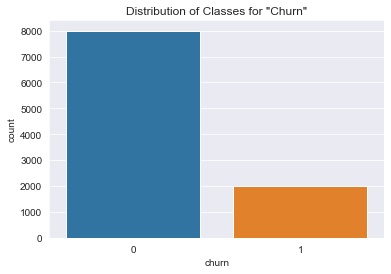

In [8]:
## check how balanced dataset is
sns.set_style("darkgrid")
sns.countplot(data["churn"])
plt.title('Distribution of Classes for "Churn"')

**Here are the key findings:**

1. Overall, it appears that the dataset is clean, with the exception of "CPL_wrt_self", which has about 10% missing values. The missingness does not appear to be systematic (among the clients with missing values, there's a variety of values for other features). There's another similar feature, "CPL_wrt_BC", which is the difference in cost per lead between the client and its business category, but it appears that there's no relationship between "CPL_wrt_self" being missing and the value for "CPL_wrt_BC".
2. Both categorical variables have high cardinality, so making dummy variables  would create 80+ low variance features and make the dataset too sparse.
3. 20% of the customers in the dataset churned while the other 80% stayed, so the dataset is imbalanced.

### Data Cleaning and Feature Engineering

Now that I have a better understanding of the dataset, here's what I will do before modeling:

1. Impute the missing values for "CPL_wrt_self". I'll use nearest neighbors imputation, which replaces missing values for a given observation with the average value for the 5 observations in the dataset that's closest (i.e. most similar) to that observation using a nearest neighbors algorithm. This is better than mean imputation because while mean imputation is unbiased, it adds no information and can introduce bias if the missingness is not random.
2. Use likelihood encoding for the categorical variables, which essentially encodes each class of a categorical feature with the mean target value within that class, given some regularization. This wallows me to create labels that are directly correlated with the target.

I considered resampling the data to correct the imbalance (i.e. using SMOTE to generate synthetic observations for clients who churned), but it's challenging to make any inference using models trained on resampled/synthetic data. Since we may want to use these models to identify the factors that cause clients to churn, I chose not to resample here and will address the imbalance in the next section.

In [9]:
X = data.drop(["churn"], axis=1)
Y = data["churn"]

In [10]:
## use likelihood encoding to transform categorical variables
ce_target = ce.TargetEncoder(cols = ["BC", "client_state"])
X = ce_target.fit_transform(X, Y)

In [11]:
## use KNN imputation to impute NA's
imputer = KNNImputer(n_neighbors=5)
imputed_X = imputer.fit_transform(X)

clean_X = pd.DataFrame(imputed_X)
clean_X.columns = X.columns

In [12]:
clean_X.head(10)

,CPL_wrt_BC,client_state,duration,num_prods,calls,CPL_wrt_self,avg_budget,BC,clicks
0,0.000000,0.223022,73.0,6.0,2.0,-0.041717,10082.152554,0.153061,107.0
1,-0.623618,0.193123,1.0,1.0,3.0,0.000000,133.928571,0.120924,79.0
2,0.007905,0.164134,102.0,2.0,8.0,-0.292008,3935.017462,0.174737,90.0
3,-0.104900,0.218978,6.0,1.0,5.0,0.587206,461.538462,0.187500,112.0
4,-0.013057,0.163265,34.0,1.0,6.0,-0.955335,314.705882,0.246493,95.0
5,-0.099898,0.187302,78.0,1.0,2.0,-0.246108,1759.027113,0.120924,92.0
6,-0.097934,0.152778,72.0,2.0,1.0,0.111382,1217.301833,0.221477,91.0
7,-0.036812,0.164134,6.0,1.0,4.0,-0.376698,5376.736111,0.251928,118.0
8,0.000000,0.176316,53.0,2.0,3.0,0.571958,2812.286923,0.201149,113.0
9,-0.108222,0.164134,45.0,1.0,6.0,-0.176777,1178.372327,0.221477,104.0


### Model Fitting

For this classification problem, I will fit the following models: logistic regression, decision tree, SVM, random forest, GBM. I will set aside 20% of the data as a test set, use 5-fold cross validation on the training set to tune the hyperparameters as needed, and pick the model that performs best on the test set as the final model.  

Since the target variable is imbalanced and I decided not to use resampling to balance out the dataset, I will use weighing to account for the imbalance. By assigning class weights to the models, I'm penalizing misclassifications of the minority class more heavily. In this case, there are 4 times as many retentions as churns, so I will penalize the model 4 times as hard for misclassifying a client who actually churned.

Lastly, I will use recall score as my metric. Recall answers the question: out of the clients who actually churned, how many did the model predict would churn? 

Recall is a useful metric in this case because the goal is to predict customers that churn, so I want the model to be able to correctly identify the relatively small proportion of customers who actually churned. Essentially, I'm willing to misidentify a client who stays as a client who churns if it means I can correctly classify more clients that actually churn. Optimizing for recall will allow the model to better predict which clients will churn and allow us to give retention offers to the clients we are likely to lose. 

In [13]:
## split data into test and training sets
X_train, X_test, Y_train, Y_test = train_test_split(clean_X, Y, test_size=0.2, random_state=100)

#### Logistic Regression

In [14]:
logistic_model = LogisticRegression(random_state=10, max_iter=1000, penalty='none', class_weight={0:1,1:4})
logistic_model.fit(X_train, Y_train)
logistic_preds = logistic_model.predict(X_test)
print("The logistic regression model has a recall of: {}".format(recall_score(logistic_preds, Y_test)))

The logistic regression model has a recall of: 0.224


#### Decision Tree

In [15]:
decision_tree = DecisionTreeClassifier(class_weight={0:1,1:4}, random_state=5)
decision_tree.fit(X_train, Y_train)
tree_preds = decision_tree.predict(X_test)
print("The decision tree has a recall of: {}".format(recall_score(tree_preds, Y_test)))

The decision tree has a recall of: 0.3646112600536193


#### Support Vector Machine

In [16]:
## note: SVM's converge faster when data is normalized, but since this didn't take long to run I will skip normalizing
svm_model = svm.SVC(kernel='rbf', random_state=5, class_weight={0:1,1:4})

## initialize parameter space and find optimal hyperparameters
parameters = {'C': [.01, .1, .5, 1, 5, 10, 100]}

np.random.seed(seed=1000)
svm_gridcv = GridSearchCV(estimator = svm_model, param_grid = parameters, cv = 5, scoring = 'recall')
svm_gridcv.fit(X_train, Y_train)

print(svm_gridcv.best_params_)

{'C': 0.01}


In [17]:
## compute recall score for optimized model
svm_mod = svm.SVC(kernel = 'rbf', C=.01, random_state=5, class_weight={0:1,1:4})
svm_mod.fit(X_train, Y_train)
svm_preds = svm_mod.predict(X_test)
print("The best SVM model has a recall of: {}".format(recall_score(svm_preds, Y_test)))

The best SVM model has a recall of: 0.2118081180811808


#### Random Forest

In [18]:
## random forest
rf_model = RandomForestClassifier(random_state = 5, class_weight={0:1,1:4})

## initialize parameter space and find optimal hyperparameters
parameters = {'n_estimators': np.arange(30, 601, 30)}

np.random.seed(seed=1000)
rf_gridcv = GridSearchCV(estimator = rf_model, param_grid = parameters, cv = 5, scoring = 'recall')
rf_gridcv.fit(X_train, Y_train)

print(rf_gridcv.best_params_)

{'n_estimators': 300}


In [19]:
## compute recall score for optimized model
rf_mod = RandomForestClassifier(n_estimators = 300, class_weight={0:1,1:4}, random_state=5)
rf_mod.fit(X_train, Y_train)
rf_preds = rf_mod.predict(X_test)
print("The best random forest model has a recall of: {}".format(recall_score(rf_preds, Y_test)))

The best random forest model has a recall of: 0.6875


#### Gradient Boosting Machine

In [20]:
## gradient boosting machine
gb_model = GradientBoostingClassifier(random_state = 5)

## initialize parameter space and find optimal hyperparameters
rates = [.01, .1, .25, .5, .75, 1]
ntrees = [x for x in np.arange(100, 501, 100)]

parameters = {'learning_rate': rates,
              'n_estimators': ntrees}

np.random.seed(seed=1000)
gbm_gridcv = GridSearchCV(estimator = gb_model, param_grid = parameters, cv = 5, scoring = 'recall')
gbm_gridcv.fit(X_train, Y_train)

print(gbm_gridcv.best_params_)

{'learning_rate': 1, 'n_estimators': 400}


In [21]:
## compute recall score for optimized model
gbm_mod = GradientBoostingClassifier(learning_rate = 1, n_estimators = 400)
gbm_mod.fit(X_train, Y_train)
gbm_preds = gbm_mod.predict(X_test)
print("The best GBM model has a recall of: {}".format(recall_score(gbm_preds, Y_test)))

The best GBM model has a recall of: 0.44694533762057875


### Summary

Here is how each model (after optimizing hyperparameters) performed on the test set, using recall as the metric:
1. Logistic Regression: .224
2. Decision Tree: .365
3. SVM: .212
4. Random Forest: .688
5. GBM: .455

The random forest with 300 trees performed best by far, so I will use that as the final model. Let's see how it performed in terms of accuracy as well.

In [22]:
print("Random Forest Accuracy: {}".format(accuracy_score(rf_preds, Y_test)))
print("Random Forest Recall: {}".format(recall_score(rf_preds, Y_test)))

Random Forest Accuracy: 0.8255
Random Forest Recall: 0.6875


In [23]:
## get a sense of feature importance based on random forest
importances = rf_mod.feature_importances_
most_important_idx = importances.argsort()
features = X_train.columns

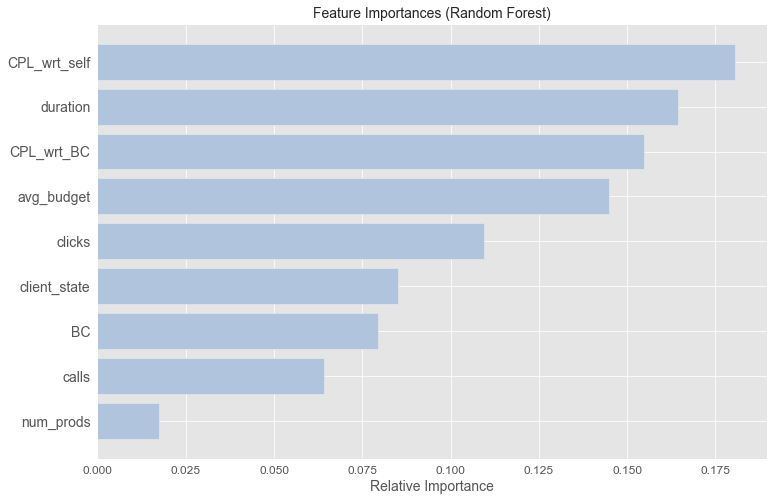

In [36]:
plt.figure(figsize=(12,8))
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=14)
plt.rc('axes', titlesize=14)   
plt.rc('axes', labelsize=14)
plt.title('Feature Importances (Random Forest)')
plt.barh(range(len(most_important_idx)), importances[most_important_idx], color='lightsteelblue', align='center')
plt.yticks(range(len(most_important_idx)), [features[i] for i in most_important_idx])
plt.xlabel('Relative Importance')
plt.show()